PHASE 0 - IMPORT DATASET

In [106]:
# Import basic libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import  ModelCheckpoint
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error, mean_squared_error


In [107]:
# Read the dataset
DataFrame = pd.read_csv('data.csv')

PHASE 1 - PREPROCESSING

In [108]:
#Drop useles columns
DataFrame = DataFrame.drop(['Unnamed: 6','Unnamed: 7', 'Unnamed: 8'], axis=1)

In [109]:
DataFrame.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 651185 entries, 0 to 651184
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   from_node  651185 non-null  int64  
 1   to_node    651185 non-null  int64  
 2   Ptran      651184 non-null  float64
 3   Prec       651185 non-null  float64
 4   RSSI       651185 non-null  float64
 5   PDR        651185 non-null  float64
dtypes: float64(4), int64(2)
memory usage: 29.8 MB


In [110]:
# Limit the decimal points to 4
DataFrame['Prec'] = DataFrame['Prec'].round(decimals=4)
DataFrame['RSSI'] = DataFrame['RSSI'].round(decimals=4)

In [111]:
#Drop NaN rows if they exist
DataFrame = DataFrame.dropna()

In [112]:
#Drop rows with 0 in PDR as they work as outliers
DataFrame.drop(DataFrame[DataFrame['PDR'] == 0].index, inplace = True)
#Drop rows wih PDR over 1 as they work as outliers
DataFrame.drop(DataFrame[DataFrame['PDR'] > 1].index, inplace = True)

In [113]:
# Forward fill PDR for each link
DataFrame['PDR'] = DataFrame.groupby(['from_node', 'to_node'])['PDR'].ffill().fillna(0)

In [114]:
# Reindex the dataframe after deletion of rows
DataFrame.reset_index(drop=True, inplace=True)

In [115]:
#Drop the from_node and to_node as they are not needed for our model
DataFrame = DataFrame.drop(['from_node','to_node'], axis=1)

In [116]:
#Print the final data
DataFrame

,Ptran,Prec,RSSI,PDR
0,-1.0,-67.9637,-1200.2879,1.000000
1,-1.0,-67.9637,-895.0007,1.000000
2,-1.0,-67.9637,-1200.2879,1.000000
3,-1.0,-88.5280,-874.4364,0.999432
4,-1.0,-66.3056,-992.4616,1.000000
...,...,...,...,...
6087,7.0,-79.0754,-647.7996,1.000000
6088,7.0,-80.4640,-1029.7147,1.000000
6089,7.0,-79.8773,-1193.2674,1.000000
6090,7.0,-81.8447,-1045.0763,0.999999


PHASE 2 - DATA VISUALIZATION

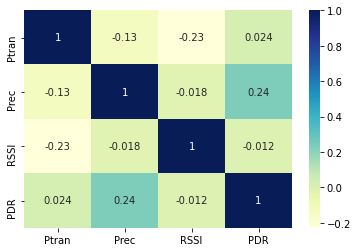

In [117]:
# Show the correlation of data using Heatmap
sns.heatmap(DataFrame.corr(), annot=True, cmap="YlGnBu")
plt.show()
#Based in the plot bellow, we can conclude that no varriable is correlated among other varriables

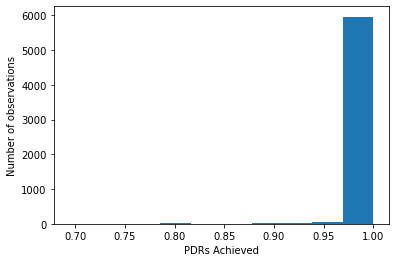

In [118]:
# Visualize 'PDR' column using histogram
plt.hist(DataFrame['PDR'])
plt.xlabel('PDRs Achieved')
plt.ylabel('Number of observations')
plt.show()

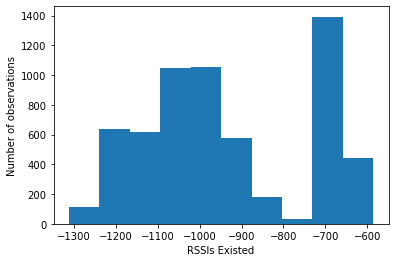

In [119]:
# Visualize 'RSSI' column using histogram
plt.hist(DataFrame['RSSI'])
plt.xlabel('RSSIs Existed')
plt.ylabel('Number of observations')
plt.show()

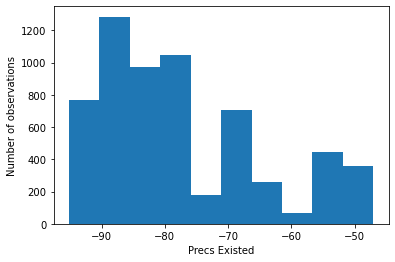

In [120]:
# Visualize 'Prec' column using histogram
plt.hist(DataFrame['Prec'])
plt.xlabel('Precs Existed')
plt.ylabel('Number of observations')
plt.show()

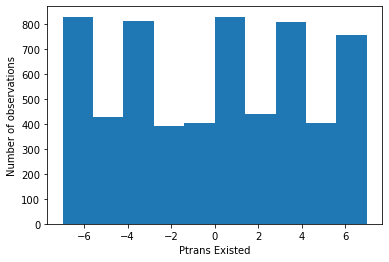

In [121]:
# Visualize 'Ptrab' column using histogram
plt.hist(DataFrame['Ptran'])
plt.xlabel('Ptrans Existed')
plt.ylabel('Number of observations')
plt.show()

In [122]:
DataFrame

,Ptran,Prec,RSSI,PDR
0,-1.0,-67.9637,-1200.2879,1.000000
1,-1.0,-67.9637,-895.0007,1.000000
2,-1.0,-67.9637,-1200.2879,1.000000
3,-1.0,-88.5280,-874.4364,0.999432
4,-1.0,-66.3056,-992.4616,1.000000
...,...,...,...,...
6087,7.0,-79.0754,-647.7996,1.000000
6088,7.0,-80.4640,-1029.7147,1.000000
6089,7.0,-79.8773,-1193.2674,1.000000
6090,7.0,-81.8447,-1045.0763,0.999999


PHASE 3 - Split Dataset Into Features And Labels (For Every Model)

In [123]:
#For First Model 
features1 = DataFrame[['Ptran','Prec','RSSI']]
labels1 = DataFrame['PDR']

#For Second Model
features2 = DataFrame[['Prec','RSSI','PDR']]
labels2 = DataFrame['Ptran']

,mean,std
Ptran,-0.082896,4.292215
Prec,-77.640682,12.753389
RSSI,-933.253025,193.520664


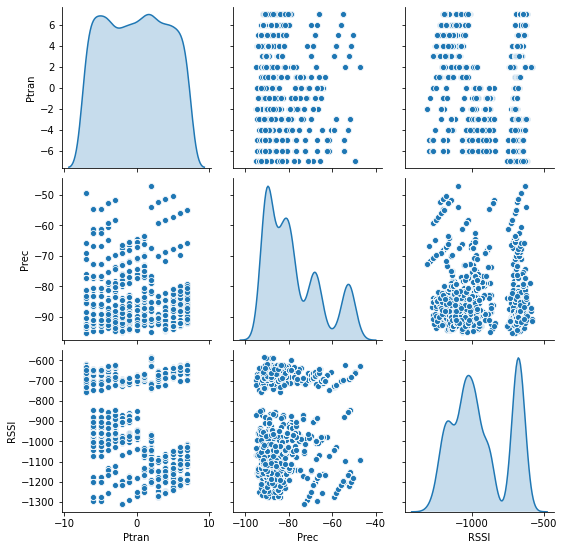

In [124]:
#Plot and describe the features dataset to understand them better

#First Model
sns.pairplot(features1[['Ptran', 'Prec', 'RSSI']], diag_kind='kde')

#Check some stats (std = The standard deviation is the average amount of variability in the dataset)
features1.describe().transpose()[['mean', 'std']]

,mean,std
Prec,-77.640682,12.753389
RSSI,-933.253025,193.520664
PDR,0.996543,0.017602


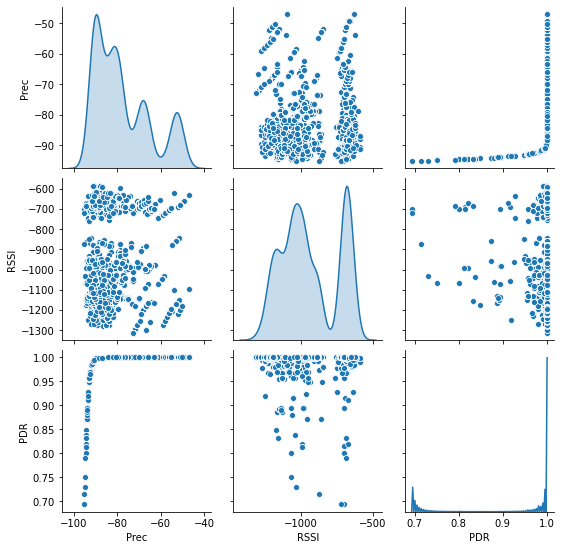

In [125]:
#Plot and describe the features dataset to understand them better

#Second Model
sns.pairplot(features2[[ 'Prec', 'RSSI', 'PDR']], diag_kind='kde')

#Check some stats (std = The standard deviation is the average amount of variability in the dataset)
features2.describe().transpose()[['mean', 'std']]

PHASE 4 - Train And Test Datasets (For Every Model)

In [126]:
# Split the data into train and test sets for first model
features_train1, features_test1, labels_train1, labels_test1 = train_test_split(features1, labels1, test_size=0.2, random_state=42)

# Split the data into train and test sets fro second model
features_train2, features_test2, labels_train2, labels_test2 = train_test_split(features2, labels2, test_size=0.2, random_state=42)

PHASE 5 - Scaling Using MinMax and Standard Scaler(For Every Model)

In [127]:
#First Model

# Scale the features using standard scaling
scaler1 = StandardScaler()
features_train = scaler1.fit_transform(features_train1)
features_test = scaler1.transform(features_test1)

# Scale the labels using MinMax scaling
label_scaler1 = MinMaxScaler()
labels = label_scaler1.fit_transform(labels1.values.reshape(-1, 1))

In [128]:
#Second Model

# Scale the features using standard scaling
scaler2 = StandardScaler()
features_train2 = scaler2.fit_transform(features_train2)
features_test2 = scaler2.transform(features_test2)

# Scale the labels using MinMax scaling
label_scaler2 = MinMaxScaler([-7,7])
labels2 = label_scaler2.fit_transform(labels2.values.reshape(-1, 1))

PHASE 6 - REGRESSION WITH NEURAL NETWORK 

First approach --> Trying Ptran tiers(-7 to 7 with step = 1) and predict the expected PDR

In [129]:
# Define the first model architecture
model1 = Sequential()
model1.add(Dense(32, input_dim=features_train.shape[1], activation=keras.layers.LeakyReLU(alpha=0.01)))
model1.add(Dense(16, activation=keras.layers.LeakyReLU(alpha=0.01)))
model1.add(Dense(1))  # Linear activation function for regression

# Compile the model
model1.compile(loss='mean_squared_error', optimizer='adam')

# Train the model
history1 =model1.fit(features_train, labels_train1, epochs=5, batch_size=32, validation_split=0.2)

Epoch 1/5
122/122 [==============================] - 1s 3ms/step - loss: 0.2894 - val_loss: 0.0343
Epoch 2/5
122/122 [==============================] - 0s 2ms/step - loss: 0.0228 - val_loss: 0.0107
Epoch 3/5
122/122 [==============================] - 0s 2ms/step - loss: 0.0064 - val_loss: 0.0028
Epoch 4/5
122/122 [==============================] - 0s 2ms/step - loss: 0.0017 - val_loss: 0.0011
Epoch 5/5
122/122 [==============================] - 0s 2ms/step - loss: 9.0834e-04 - val_loss: 8.1816e-04


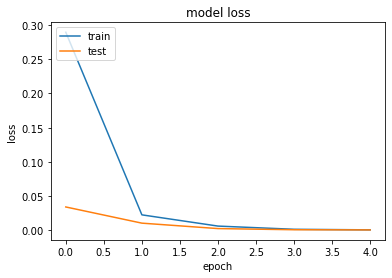

In [130]:
# summarize history for loss for first model
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [131]:
# Evaluate loss for first  model
loss = model1.evaluate(features_test, labels_test1)
print(f'Test Loss: {loss}')


39/39 [==============================] - 0s 1ms/step - loss: 8.9183e-04
Test Loss: 0.0008918281528167427


Second Approach --> Given an expected PDR calculate the desired Ptran

In [132]:
# Define the second model architecture
model2= Sequential()
model2.add(Dense(64, input_dim=features_train.shape[1], activation=keras.layers.LeakyReLU(alpha=0.01)))
model2.add(Dropout(0.2)) # Introducing Dropout Layers to enchance the performance
model2.add(Dense(32, activation=keras.layers.LeakyReLU(alpha=0.01)))
model2.add(Dropout(0.2))
model2.add(Dense(16, activation=keras.layers.LeakyReLU(alpha=0.01)))
model2.add(Dropout(0.2))
model2.add(Dense(1))  # Linear activation function for regression

# Compile the model
model2.compile(loss='mean_squared_error', optimizer='adam')

# Define  model checkpointing
model2_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True) #Introducing  Model Checkpoints  to enchance the performance

# Train the model
history2 = model2.fit(features_train, labels_train2, epochs=150, batch_size=32, validation_split=0.2, callbacks=[ model2_checkpoint])

# Load the best model
model2.load_weights('best_model.h5')

Epoch 1/150
122/122 [==============================] - 1s 3ms/step - loss: 8.9639 - val_loss: 0.3062
Epoch 2/150
122/122 [==============================] - 0s 3ms/step - loss: 1.8651 - val_loss: 0.1327
Epoch 3/150
122/122 [==============================] - 0s 2ms/step - loss: 1.5010 - val_loss: 0.2506
Epoch 4/150
122/122 [==============================] - 0s 2ms/step - loss: 1.3519 - val_loss: 0.0914
Epoch 5/150
122/122 [==============================] - 0s 2ms/step - loss: 1.2767 - val_loss: 0.1538
Epoch 6/150
122/122 [==============================] - 0s 2ms/step - loss: 1.1655 - val_loss: 0.1434
Epoch 7/150
122/122 [==============================] - 0s 2ms/step - loss: 1.1870 - val_loss: 0.1045
Epoch 8/150
122/122 [==============================] - 0s 3ms/step - loss: 1.1144 - val_loss: 0.0744
Epoch 9/150
122/122 [==============================] - 0s 3ms/step - loss: 1.0956 - val_loss: 0.1441
Epoch 10/150
122/122 [==============================] - 0s 2ms/step - loss: 1.0012 - val_lo

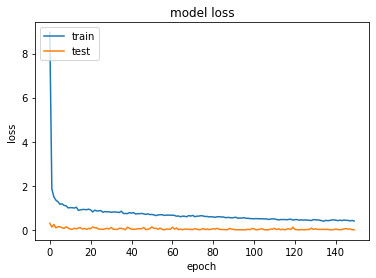

In [133]:
# summarize history for loss for second model
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

PHASE 7 - Make Predictions(For Every Model)

For First Model

39/39 [==============================] - 0s 1ms/step


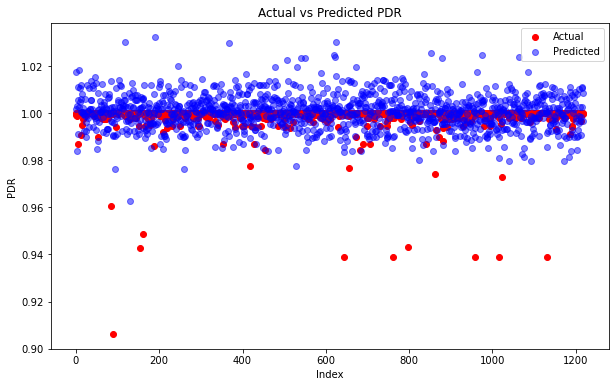

In [134]:
# Make predictions on test feautures
predictions1 = model1.predict(features_test)

#Change 2D array to 1D array to perform the inverse_transform
labels_test1 = labels_test1.values.reshape(-1, 1)
predictions1 = predictions1.reshape(-1, 1)

# Inverse scale the predictions and the labels_test for plotting
labels_test1 = label_scaler1.inverse_transform(labels_test1)
predictions1 = label_scaler1.inverse_transform(predictions1)

# Scatter plot of actual vs. predicted
plt.figure(figsize=(10, 6))

# Scatter plot of actual values, in red
plt.scatter(range(len(labels_test1)), labels_test1, color='red', label='Actual')

# Scatter plot of predicted values, in blue
plt.scatter(range(len(predictions1)), predictions1, color='blue', alpha=0.5, label='Predicted')

plt.title('Actual vs Predicted PDR')
plt.xlabel('Index')
plt.ylabel('PDR')
plt.legend()
plt.show()

For Second Model

39/39 [==============================] - 0s 2ms/step


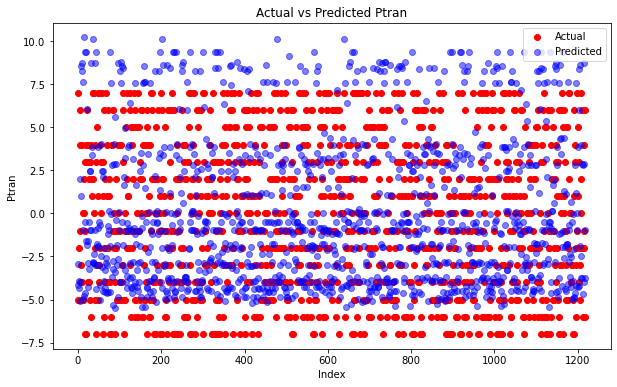

In [135]:
# Generate predictions on test data
predictions2 = model2.predict(features_test2)

#Change 2D array to 1D array to perform the inverse_transform
#labels_test2 = labels_test2.values.reshape(-1, 1)
#predictions2 = predictions2.reshape(-1, 1)

# Inverse scale the predictions and the labels_test for plotting
#labels_test2 = label_scaler2.inverse_transform(labels_test2)
#predictions2 = label_scaler2.inverse_transform(predictions2)


# Scatter plot of actual vs. predicted
plt.figure(figsize=(10, 6))
plt.scatter(range(len(labels_test2)), labels_test2, color='red', label='Actual')
plt.scatter(range(len(predictions2)), predictions2, color='blue', alpha=0.5, label='Predicted')
plt.title('Actual vs Predicted Ptran')
plt.xlabel('Index')
plt.ylabel('Ptran')
plt.legend()
plt.show()

PHASE 8 - Perform Single Datapoints Predictions For Every Model (For Testing Purpose)

Example --> First Record =  "Ptran": [-1], "Prec": [-67.9637], "RSSI": [-1200.2879], "PDR": [1.000000]

In [136]:
#For First Model
# Change the feautures values(Ptran,Prec,RSSI) and see the predicted label(PDR):
test_data_1 = pd.DataFrame({"Ptran": [-1], "Prec": [-67.9637], "RSSI": [-1200.2879]})

# Scale the data
test_data_scaled_1 = scaler1.transform(test_data_1)

# Predict the PDR using the model
prediction_test_1 = model1.predict(test_data_scaled_1)

# Rescale the prediction back to the original scale
test_prediction_1 = label_scaler1.inverse_transform(prediction_test_1)

#Print the one-data-point prediction
test_prediction_1

1/1 [==============================] - 0s 28ms/step


array([[1.0030725]], dtype=float32)

In [137]:
#For Second Model example: exp:-67.9637	-1200.2879	1.000000
# Change the feautures values(Prec,RSSI,PDR) and see the predicted label(Ptran):
test_data_2 = pd.DataFrame({"Prec": [-67.9637], "RSSI": [-1200.2879], "PDR": [1.000000]})

# Scale the data
test_data_scaled_2 = scaler2.transform(test_data_2)

## Predict the PDR using the model
prediction_test_2 = model2.predict(test_data_scaled_2)

#Rescale the prediction back to the original scale
test_prediction_2 = label_scaler2.inverse_transform(prediction_test_2)

#Print the one-data-point prediction
test_prediction_2

1/1 [==============================] - 0s 20ms/step


array([[3.2010787]], dtype=float32)

PHASE 9 - Evaluate Models Using R^2 Score 

In [138]:
# For the first model

# Calculate R^2 score
r2_1 = r2_score(labels_test1, predictions1)
print(f'R^2 score: {r2_1}')

R^2 score: -1.3775344480280123


In [139]:
# For the Second model

# Calculate R^2 score
r2_2 = r2_score(labels_test2, predictions2)
print(f'R^2 score: {r2_2}')

R^2 score: -1.3127929891858074


PHASE 10 - Evaluate Models Using  Mean Absolute Error, Mean Squared Error, Root Mean Squared Error  

In [140]:
# Calculate the errors for first model
mae1 = mean_absolute_error(labels_test1, predictions1)
mse1 = mean_squared_error(labels_test1, predictions1)
rmse1 = np.sqrt(mse1)

print(f"Mean Absolute Error: {mae1}")
print(f"Mean Squared Error: {mse1}")
print(f"Root Mean Squared Error: {rmse1}")

Mean Absolute Error: 0.006173499814489422
Mean Squared Error: 8.365493921646263e-05
Root Mean Squared Error: 0.009146307408810544


In [141]:
# Calculate the errors
mae2 = mean_absolute_error(labels_test2, predictions2)
mse2 = mean_squared_error(labels_test2, predictions2)
rmse2 = np.sqrt(mse2)

print(f"Mean Absolute Error: {mae2}")
print(f"Mean Squared Error: {mse2}")
print(f"Root Mean Squared Error: {rmse2}")

Mean Absolute Error: 5.264620435589938
Mean Squared Error: 42.35794489163958
Root Mean Squared Error: 6.508298156326243


Build In Library -- RandomForestRegressor

Ptran PREDITCTION

In [142]:
#Import Needed Libraries
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


In [143]:
# Copy the dataframe
df3 = DataFrame.copy()
df3

,Ptran,Prec,RSSI,PDR
0,-1.0,-67.9637,-1200.2879,1.000000
1,-1.0,-67.9637,-895.0007,1.000000
2,-1.0,-67.9637,-1200.2879,1.000000
3,-1.0,-88.5280,-874.4364,0.999432
4,-1.0,-66.3056,-992.4616,1.000000
...,...,...,...,...
6087,7.0,-79.0754,-647.7996,1.000000
6088,7.0,-80.4640,-1029.7147,1.000000
6089,7.0,-79.8773,-1193.2674,1.000000
6090,7.0,-81.8447,-1045.0763,0.999999


In [144]:
# Selecting features and labels
features3 = df3[["Prec", "RSSI", "PDR"]]
labels3 = df3["Ptran"]

In [145]:
# Splitting the data into training and test sets
features_train3, features_test3, labels_train3, labels_test3 = train_test_split(features3, labels3, test_size=0.2, random_state=42)

In [146]:
# Initialize Random Forest model
model3 = RandomForestRegressor(n_estimators=100, random_state=42)

# Fit the model
model3.fit(features_train3, labels_train3)

RandomForestRegressor(random_state=42)

RMSE: 0.792601


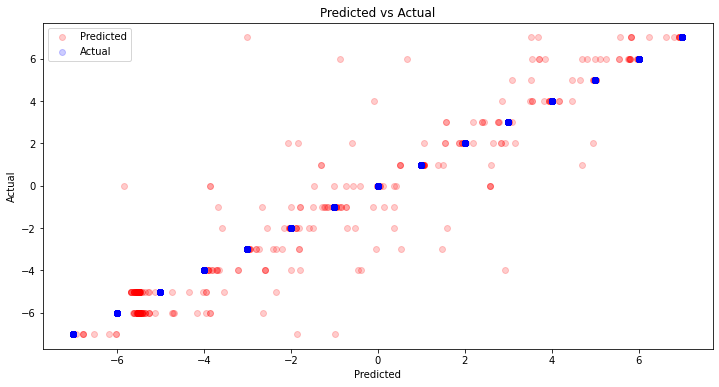

In [147]:
# Make predictions
predictions3 = model3.predict(features_test3)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(labels_test3, predictions3))
print("RMSE: %f" % (rmse))

# Plot Predicted vs Actual
plt.figure(figsize=(12, 6))
plt.scatter(predictions3, labels_test3, alpha=0.2, color='red', label='Predicted')
plt.scatter(labels_test3, labels_test3, alpha=0.2, color='blue', label='Actual')
plt.title('Predicted vs Actual')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.legend()
plt.show()

In [148]:
from sklearn.metrics import r2_score

# Calculate R-squared score
r2_3 = r2_score(labels_test3, predictions3)
print("R-squared Score: %f" % (r2_3))

R-squared Score: 0.965699


In [149]:
# Suppose you have a single data point as follows: 
# Example --> First Record =  "Ptran": [-1], "Prec": [-67.9637], "RSSI": [-1200.2879], "PDR": [1.000000]

single_data_point3 = [[-79.0754, -1200.7996,1.000000]]  # Format: [Prec, RSSI, PDR]

#Convert into numpy array
single_data_point3 = np.array(single_data_point3)

# Use the model to make a prediction
single_point_prediction3 = model3.predict(single_data_point3)

print("Predicted Ptran for the given data point: ", single_point_prediction3)

Predicted Ptran for the given data point:  [-0.66]


c:\Users\30698\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


PDR PREDICTION

In [150]:
#Copy Dataframe
df4 = DataFrame.copy()
df4

,Ptran,Prec,RSSI,PDR
0,-1.0,-67.9637,-1200.2879,1.000000
1,-1.0,-67.9637,-895.0007,1.000000
2,-1.0,-67.9637,-1200.2879,1.000000
3,-1.0,-88.5280,-874.4364,0.999432
4,-1.0,-66.3056,-992.4616,1.000000
...,...,...,...,...
6087,7.0,-79.0754,-647.7996,1.000000
6088,7.0,-80.4640,-1029.7147,1.000000
6089,7.0,-79.8773,-1193.2674,1.000000
6090,7.0,-81.8447,-1045.0763,0.999999


In [151]:
# Selecting features and labels
features4 = df4[["Ptran", "Prec", "RSSI"]]
labels4 = df4["PDR"]

In [152]:
# Splitting the data into training and test sets
features_train4, features_test4, labels_train4, labels_test4 = train_test_split(features4, labels4, test_size=0.2, random_state=42)

In [153]:
# Initialize Random Forest model
model4 = RandomForestRegressor(n_estimators=100, random_state=42)

# Fit the model
model4.fit(features_train4, labels_train4)


RandomForestRegressor(random_state=42)

RMSE: 0.000378


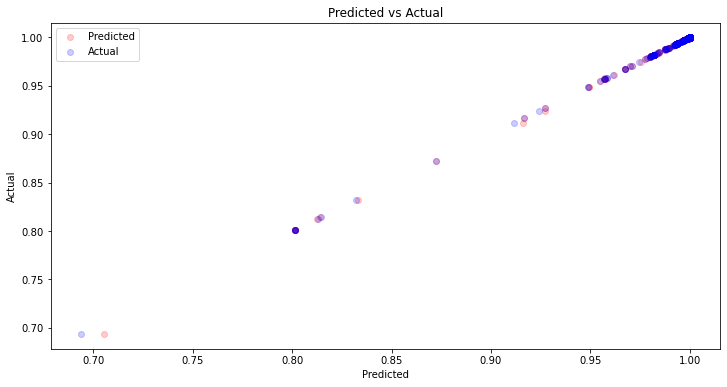

In [154]:
# Make predictions
predictions4 = model4.predict(features_test4)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(labels_test4, predictions4))
print("RMSE: %f" % (rmse))

# Plot Predicted vs Actual
plt.figure(figsize=(12, 6))
plt.scatter(predictions4, labels_test4, alpha=0.2, color='red', label='Predicted')
plt.scatter(labels_test4, labels_test4, alpha=0.2, color='blue', label='Actual')
plt.title('Predicted vs Actual')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.legend()
plt.show()

In [155]:
from sklearn.metrics import r2_score

# Calculate R-squared score
r2_4 = r2_score(labels_test4, predictions4)
print("R-squared Score: %f" % (r2_4))

R-squared Score: 0.999618


In [156]:
# Suppose you have a single data point as follows: 
# Example --> First Record =  "Ptran": [-1], "Prec": [-67.9637], "RSSI": [-1200.2879], "PDR": [1.000000]	
single_data_point4 = [[-1.0, -67.9637, -1200.2879]]  # Format: [Ptran, Prec, RSSI]

# Ensure the single_data_point is a numpy array
single_data_point4 = np.array(single_data_point4)

# Use the model to predict
single_point_prediction4 = model4.predict(single_data_point4)

print("Predicted PDR for the given data point: ", single_point_prediction4)

Predicted PDR for the given data point:  [0.99999999]


c:\Users\30698\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
